# Projet 7 - OpenClassRoom

# Implémentez un modèle de scoring
### Notebook consacré à l'élaboration du modèle

A partir d'un exemple disponible sur Kaggle.com (start-here-a-gentle-introduction)


## Imports


In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Variable globale contenant le mode de re-sampling
mode_sampling = ''

In [2]:
from generic_function import *

## Read in Data 

In [4]:
# List files available
print(os.listdir("C:/Data/OC-DataScientist/Projet7/Dataset/Data"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'Projet+Mise+en+prod+-+home-credit-default-risk.zip', 'sample_submission.csv']


In [5]:
# Training data
app_train = pd.read_csv('C:/Data/OC-DataScientist/Projet7/Dataset/Data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [6]:
# Dataset réduit pour le Dashboard. Pas de fichiers de plus de 50Mo sur Github
app_train_reduit = app_train.loc[0:100000,:]
app_train_reduit.to_csv('application_train_reduit.csv')

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [5]:
# Testing data features
app_test = pd.read_csv('C:/Data/OC-DataScientist/Projet7/Dataset/Data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

# Analyse des données

## Distribution de la colonne Target

- target = 0 si remboursement à temps
- target = 1 si défaut de remboursement

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

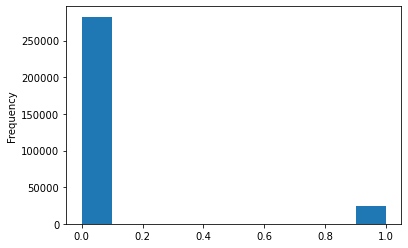

In [7]:
app_train['TARGET'].astype(int).plot.hist();

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Missing Values

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [11]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

### Label Encoding and One-Hot Encoding

In [12]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [13]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)


Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data
Comme on a fait du OneHotEncoding, il se trouve que dans le TestSet, toutes les catégories correspondantes ne sont pas représentées. Il faut le créer pour aligner le format des deux Set

In [14]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

### Anomalies

In [15]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [16]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

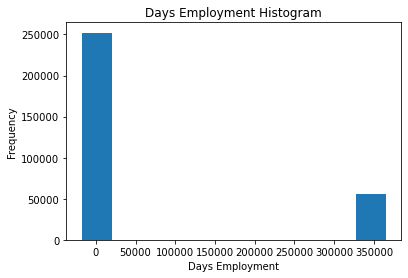

In [17]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [18]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



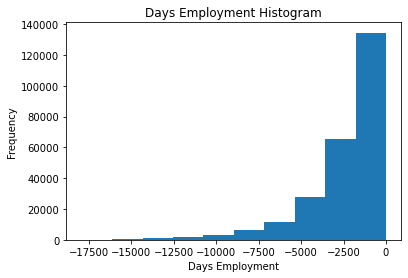

In [19]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data.

In [20]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

In [21]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [22]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

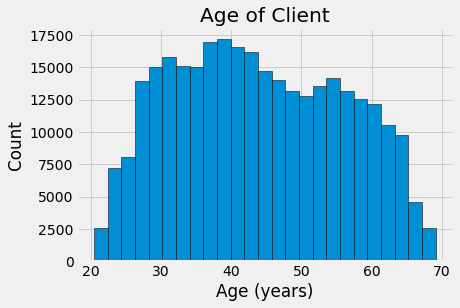

In [23]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

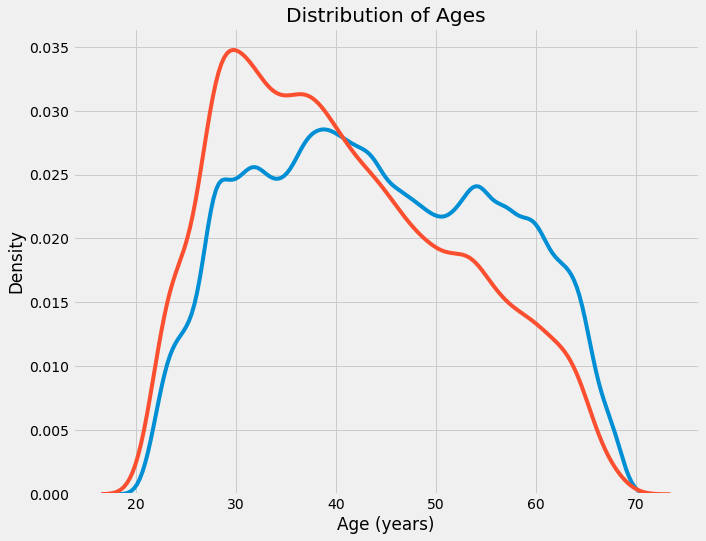

In [24]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [25]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [26]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

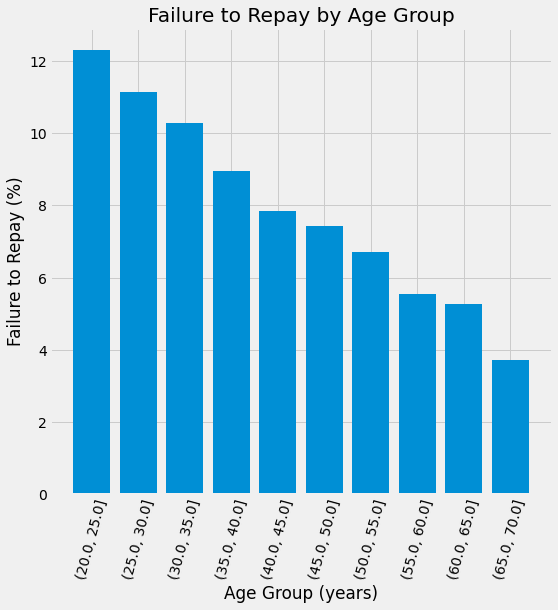

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [28]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

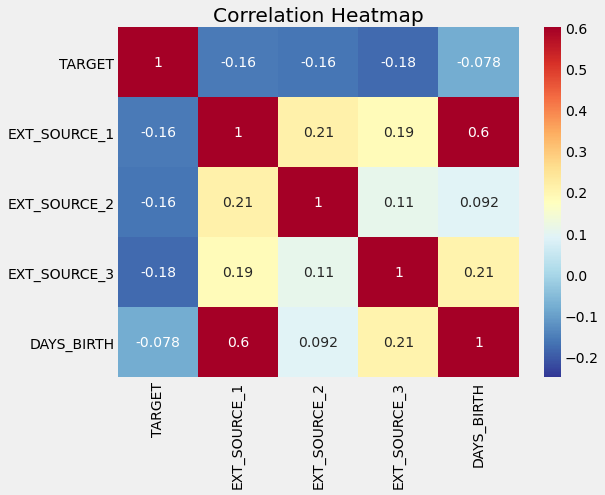

In [29]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

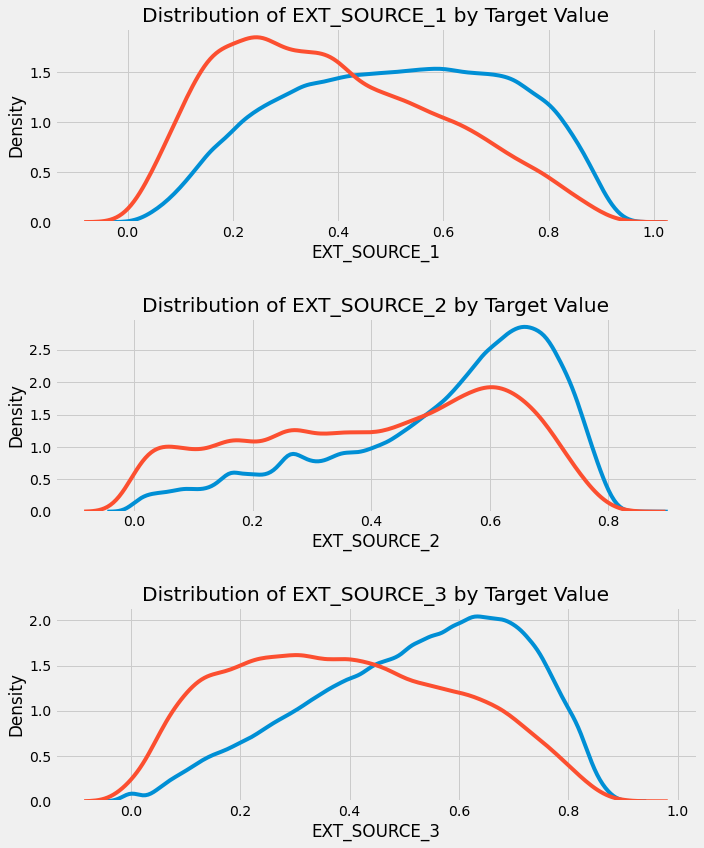

In [30]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

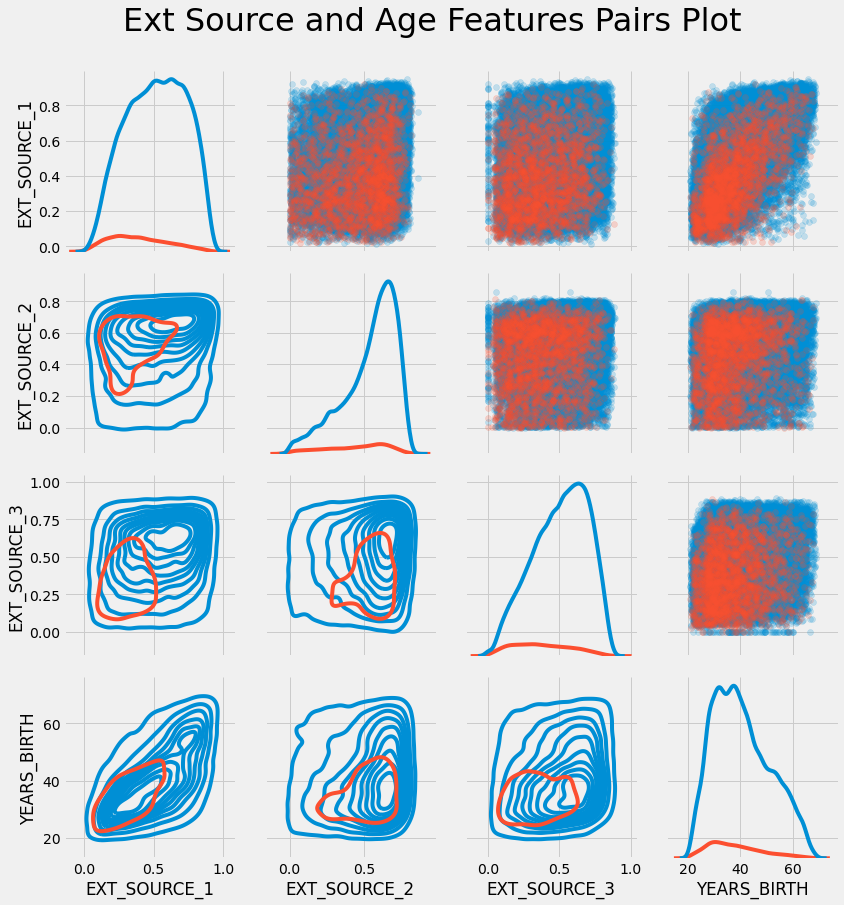

In [31]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Feature Engineering

* Polynomial features
* Domain knowledge features


## Polynomial Features

In [32]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [33]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [34]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [35]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [36]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [37]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [38]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

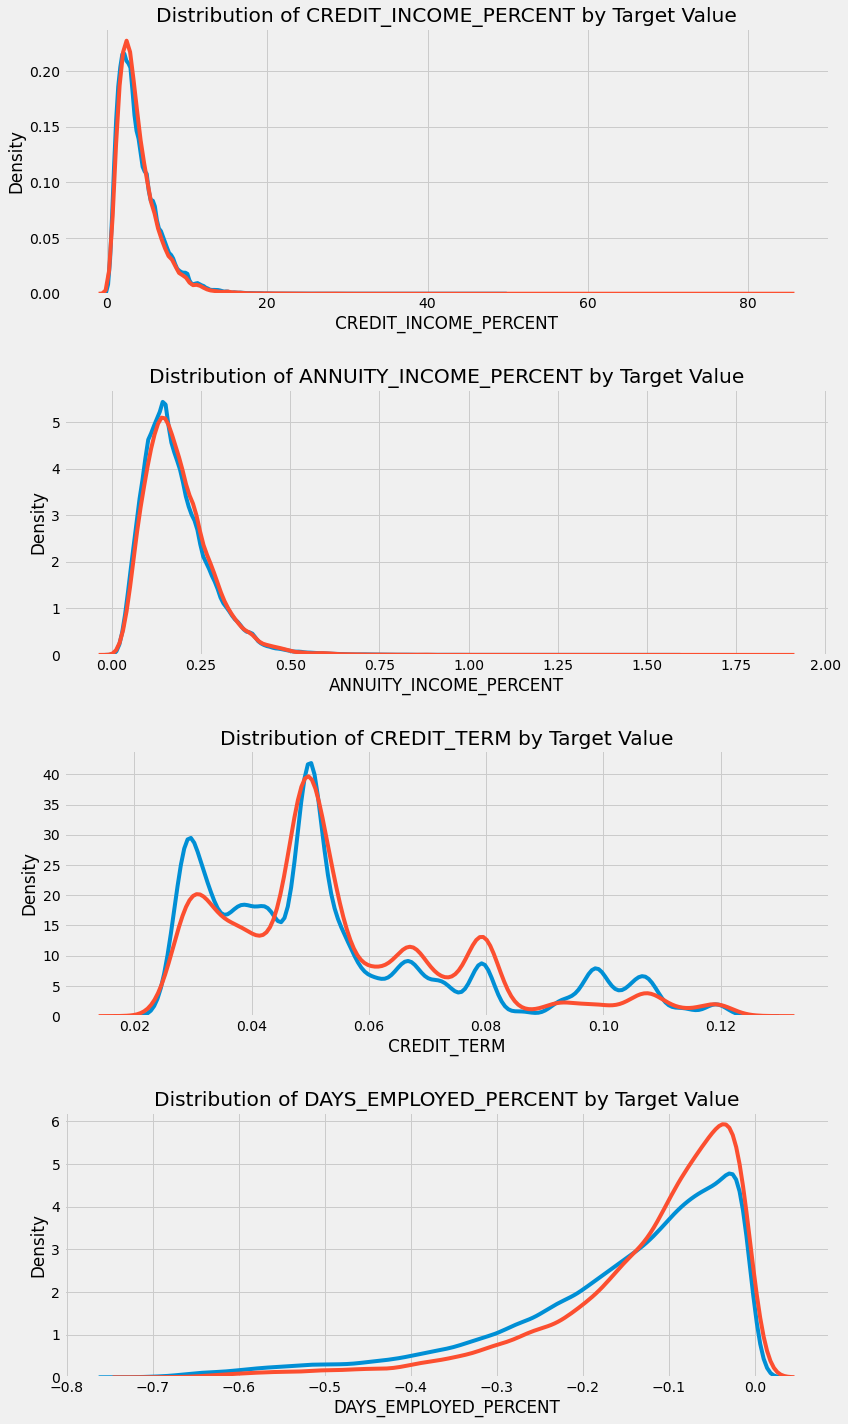

In [39]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Baseline

### On prend la Regression Logistique comme baseline

In [40]:
def preprocesseur(df_train, df_test):
    
    # Drop the target from the training data
    if "TARGET" in df_train:
        train = df_train.drop(columns = ["TARGET"])
    else:
        train = df_train.copy()
        
    # Feature names
    features = list(train.columns)


    # Median imputation of missing values
    imputer = SimpleImputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Replace the boolean column by numerics values 
    train["DAYS_EMPLOYED_ANOM"] = train["DAYS_EMPLOYED_ANOM"].astype("int")

    # Fit on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train = imputer.transform(train)
    test = imputer.transform(df_test)

    # Repeat with the scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    
    return train, test

In [41]:
def echantillonage(df_X, df_y):

    X = df_X.copy()
    y = df_y.copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test

## Preprocessing des données
- sans feature engineering
- avec features polynomial
- avec feature engineering du domaine fonctionnel


In [42]:
%%time

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

app_train.drop(columns="SK_ID_CURR", inplace=True)
app_test.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing sans feature engineering")
train, test = preprocesseur(app_train, app_test)
print("Echantillonage : train = 80% | test = 20%")
X_train, X_test, y_train, y_test = echantillonage(train, app_train["TARGET"])
print("X_train shape :", X_train.shape)
print("X_test shape :", X_test.shape)
print("")


app_train_poly.drop(columns="SK_ID_CURR", inplace=True)
app_test_poly.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing avec features polynomial")
train_poly, test_poly = preprocesseur(app_train_poly, app_test_poly)
print("Echantillonage : train = 80% | test = 20%")
X_train_poly, X_test_poly, y_train_poly, y_test_poly = echantillonage(train_poly, app_train["TARGET"])
print("X_train shape :", X_train_poly.shape)
print("X_test shape :", X_test_poly.shape)
print("")


app_train_domain.drop(columns="SK_ID_CURR", inplace=True)
app_test_domain.drop(columns="SK_ID_CURR", inplace=True)

print("Preprocessing avec feature engineering du domaine fonctionnel")
train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain)
print("Echantillonage : train = 80% | test = 20%")
X_train_domain, X_test_domain, y_train_domain, y_test_domain = echantillonage(train_domain, app_train["TARGET"])
print("X_train shape :", X_train_domain.shape)
print("X_test shape :", X_test_domain.shape)


Preprocessing sans feature engineering
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 239)
X_test shape : (61503, 239)

Preprocessing avec features polynomial
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 274)
X_test shape : (61503, 274)

Preprocessing avec feature engineering du domaine fonctionnel
Echantillonage : train = 80% | test = 20%
X_train shape : (246008, 243)
X_test shape : (61503, 243)
Wall time: 8min 4s


## Regression Logistique

In [43]:
def log_reg(df_X_train, df_y_train, df_y_test, df_X_test):
    
    # Make the model with the specified regularization parameter
    log_reg = LogisticRegression(C = 0.0001)

    # Train on the training data
    log_reg.fit(df_X_train, df_y_train)
    
    y_pred = log_reg.predict(df_X_test)

    accuracy = accuracy_score(df_y_test, y_pred)
    
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    # Make predictions
    # Make sure to select the second column only
    log_reg_pred = log_reg.predict_proba(df_X_test)[:, 1]
    
    return log_reg_pred

In [44]:
def save_results(df_res, df_pred, new_col, df_index):

    df_pred_lr = pd.DataFrame(df_pred, columns=[new_col], index=df_index.index)

    df_res = pd.concat([df_res, df_pred_lr], sort=False, axis=1)
    
    return df_res

In [45]:
def transform_treshold(df, tresh):
    
    new_df = (df >= tresh).astype("int")
    
    return new_df

### Sauvegarde des Dataset. On en aura besoin dans le Dashboard

In [46]:
# Sauvegarde
app_test.to_csv('app_test.csv')
app_test_poly.to_csv('app_test_poly.csv')
app_test_domain.to_csv('app_test_domain.csv')

app_train.to_csv('app_train.csv')
app_train_poly.to_csv('app_train_poly.csv')
app_train_domain.to_csv('app_train_domain.csv')


In [47]:
# # Rechargement
# app_test = pd.read_csv('app_test.csv')
# app_test_poly = pd.read_csv('app_test_poly.csv')
# app_test_domain = pd.read_csv('app_test_domain.csv')
# app_train = pd.read_csv('app_train.csv')
# app_train_poly = pd.read_csv('app_train_poly.csv')
# app_train_domain = pd.read_csv('app_train_domain.csv')


## Détermination du meilleurs Dataset parmis les trois

### dataset 1 - Sans feature engineering



In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg_pred = log_reg(X_train, y_train, y_test, X_test)

# On enregistre les résultats
df_results_base = save_results(df_results_base, log_reg_pred, "y_pred_lr", y_test)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = transform_treshold(df_results_base["y_pred_lr"], 0.5)

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 92.11%


y_true  y_pred_lr  y_pred_lr_bin
42962        1   0.093096              0
227307       0   0.063556              0
290035       0   0.067366              0
239833       0   0.105164              0
76427        0   0.099360              0

(61503, 3)


### dataset 2 - Avec polynomial features


In [49]:
# On crée le dataframe de résultats
df_results_base_poly = pd.DataFrame(y_test_poly.values, columns=["y_true"], index=y_test_poly.index)

# On lance les prédictions
log_reg_pred = log_reg(X_train_poly, y_train_poly, y_test_poly, X_test_poly)

# On enregistre les résultats
df_results_base_poly = save_results(df_results_base_poly, log_reg_pred, "y_pred_lr_poly", y_test_poly)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_poly["y_pred_lr_poly_bin"] = transform_treshold(df_results_base_poly["y_pred_lr_poly"], 0.5)

display(df_results_base_poly.head())
print(df_results_base_poly.shape)

Accuracy: 92.11%


y_true  y_pred_lr_poly  y_pred_lr_poly_bin
42962        1        0.131928                   0
227307       0        0.040613                   0
290035       0        0.087734                   0
239833       0        0.094518                   0
76427        0        0.137051                   0

(61503, 3)


### Dataset 3 - Avec domain knowledge features


In [50]:
# On crée le dataframe de résultats
df_results_base_domain = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

# On lance les prédictions
log_reg_pred = log_reg(X_train_domain, y_train_domain, y_test_domain, X_test_domain)

# On enregistre les résultats
df_results_base_domain = save_results(df_results_base_domain, log_reg_pred, "y_pred_lr_domain", y_test_domain)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_domain["y_pred_lr_domain_bin"] = transform_treshold(df_results_base_domain["y_pred_lr_domain"], 0.5)

display(df_results_base_domain.head())
print(df_results_base_domain.shape)

Accuracy: 92.11%


y_true  y_pred_lr_domain  y_pred_lr_domain_bin
42962        1          0.093490                     0
227307       0          0.063669                     0
290035       0          0.066947                     0
239833       0          0.104526                     0
76427        0          0.098586                     0

(61503, 3)


### Confusion matrix

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [51]:
def aff_confusion_matrix(df_true, df_pred):

    conf_mat = confusion_matrix(df_true, df_pred)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(111)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
    #cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    #fig.colorbar(cax)
    #ax.set_xticklabels([''] + labels)
    #ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    


Logistic Regression base


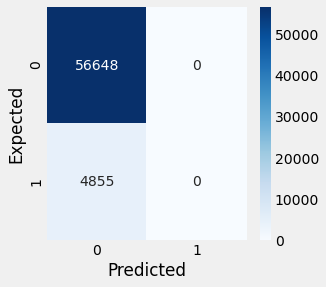

Logistic Regression polynomial features


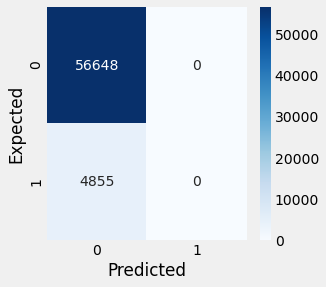

Logistic Regression domain features


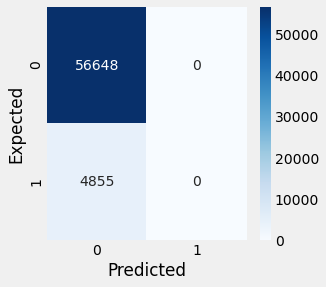

In [52]:
from sklearn.metrics import confusion_matrix
print ('Logistic Regression base')
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

print ('Logistic Regression polynomial features')
aff_confusion_matrix(df_results_base_poly["y_true"], df_results_base_poly["y_pred_lr_poly_bin"])

print ('Logistic Regression domain features')
aff_confusion_matrix(df_results_base_domain["y_true"], df_results_base_domain["y_pred_lr_domain_bin"])

#### Nous pouvons constater que l'accuracy du modèle est excellente, mais cela est dû au fait que le jeu de données est fortement déséquilibré. 

In [53]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["sans_feat_eng", "poly_feat", "domain_feat"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

df_metrics_base["Accuracy"][1] = round(accuracy_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["Precision"][1] = round(precision_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["Recall"][1] = round(recall_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["F1_score"][1] = round(f1_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)

df_metrics_base["Accuracy"][2] = round(accuracy_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Precision"][2] = round(precision_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Recall"][2] = round(recall_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["F1_score"][2] = round(f1_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)

df_metrics_base

Accuracy Precision Recall F1_score
sans_feat_eng     0.92         0      0        0
poly_feat         0.92         0      0        0
domain_feat       0.92         0      0        0

#### On ne peut pas différentier les 3 Dataset comme ça. il faut faire du resampling

# Resampling

In [54]:
print("RAPPEL - DESEQUILIBRAGE DES DONNEES")

percent0 = (y_train.value_counts()[0] / y_train.shape) * 100
percent1 = (y_train.value_counts()[1] / y_train.shape) * 100

print("Nombre d'individus pour la classe 0 :", y_train.value_counts()[0], ". Soit", percent0, "% de la population.")
print("Nombre d'individus pour la classe 1 :", y_train.value_counts()[1], ". Soit", percent1, "% de la population.")



RAPPEL - DESEQUILIBRAGE DES DONNEES
Nombre d'individus pour la classe 0 : 226038 . Soit [91.88237781] % de la population.
Nombre d'individus pour la classe 1 : 19970 . Soit [8.11762219] % de la population.


Class 0: 226038
Class 1: 19970
Proportion: 11.32 : 1


([<matplotlib.patches.Wedge at 0x1f4479e9370>,
 [Text(-0.2774940275746891, -1.0644233484194048, 'Classe 0'),
  Text(0.3027207573542064, 1.1611891073666234, 'Classe 1')],
 [Text(-0.1513603786771031, -0.5805945536833117, '91.9%'),
  Text(0.1765871084566204, 0.6773603126305303, '8.1%')])

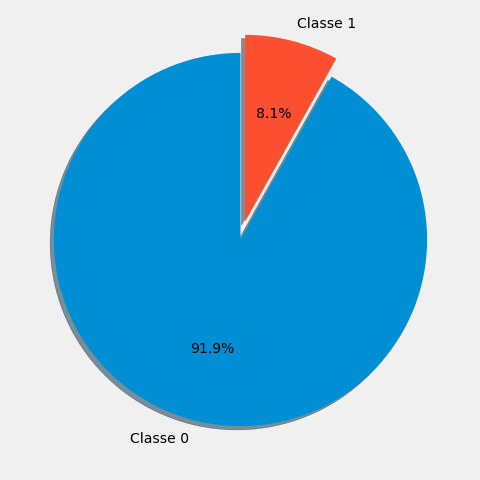

In [55]:
target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

In [56]:
import imblearn

## DS1 : Sans feature engineering
#### J'ai testé les 4 possibilités
- under_sampling
- over_sampling
- SMOTEENN (très lent)
- SMOTETomek (très lent)


In [57]:
%%time
from imblearn.under_sampling  import RandomUnderSampler
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.combine import SMOTEENN
#from imblearn.combine import SMOTETomek

# Important pour les titres des fichiers générés
mode_sampling='under_sampling' 
#mode_sampling='over_sampling' 

from collections import Counter

print("Preprocessing")
train, test = preprocesseur(app_train, app_test)

print("Resampling")
smt = RandomUnderSampler()
#smt = RandomOverSampler()
#smt = SMOTEENN()
#smt = SMOTETomek()
X_smt, y_smt = smt.fit_resample(train, app_train["TARGET"])

print('Original dataset shape %s' % Counter(app_train["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_smt))


Preprocessing
Resampling
Original dataset shape Counter({0: 282686, 1: 24825})
Resampled dataset shape Counter({0: 24825, 1: 24825})
Wall time: 6min 26s


## DS2 : Avec polynomial features

In [58]:
%%time

print("Preprocessing")
train_poly, test_poly = preprocesseur(app_train_poly, app_test_poly)

print("Resampling")
X_smt_poly, y_smt_poly = smt.fit_resample(train_poly, app_train["TARGET"])

print('Original dataset shape %s' % Counter(app_train["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_smt_poly))

Preprocessing
Resampling
Original dataset shape Counter({0: 282686, 1: 24825})
Resampled dataset shape Counter({0: 24825, 1: 24825})
Wall time: 7min 25s


## DS3 : Avec les features du domaine fonctionnel

In [59]:
%%time

print("Preprocessing")
train_domain, test_domain = preprocesseur(app_train_domain, app_test_domain)

print("Resampling")
X_smt_domain, y_smt_domain = smt.fit_resample(train_domain, app_train["TARGET"])

print('Original dataset shape %s' % Counter(app_train["TARGET"]))
print('Resampled dataset shape %s' % Counter(y_smt_domain))

Preprocessing
Resampling
Original dataset shape Counter({0: 282686, 1: 24825})
Resampled dataset shape Counter({0: 24825, 1: 24825})
Wall time: 3min 17s
Compiler : 651 ms
Parser   : 1.07 s


### Sauvegarde pour le Dashboard
- de X et y_smt_domain pour pouvoir refaire des tests
- de test_domain pour faire des prédictions


In [60]:
print (y_smt_domain.shape)
print (X_smt_domain.shape)
print (test_domain.shape)

(49650,)
(49650, 243)
(48744, 243)


In [61]:
import pickle

# saving the data
with open("y_smt_domain.bin", 'wb') as f_out:
    pickle.dump(y_smt_domain, f_out)
    f_out.close()
with open("X_smt_domain.bin", 'wb') as f_out:
    pickle.dump(X_smt_domain, f_out)
    f_out.close()
    
# saving the data
with open("y_test_domain.bin", 'wb') as f_out:
    pickle.dump(y_test_domain, f_out)
    f_out.close()
with open("X_test_domain.bin", 'wb') as f_out:
    pickle.dump(X_test_domain, f_out)
    f_out.close()

with open("test_domain.bin", 'wb') as f_out:
    pickle.dump(test_domain, f_out)
    f_out.close()



Class 0: 24825
Class 1: 24825
Proportion: 1.0 : 1


([<matplotlib.patches.Wedge at 0x1f461c913d0>,
 [Text(-1.1, 1.3471114790620887e-16, 'Classe 0'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'Classe 1')],
 [Text(-0.6, 7.347880794884119e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

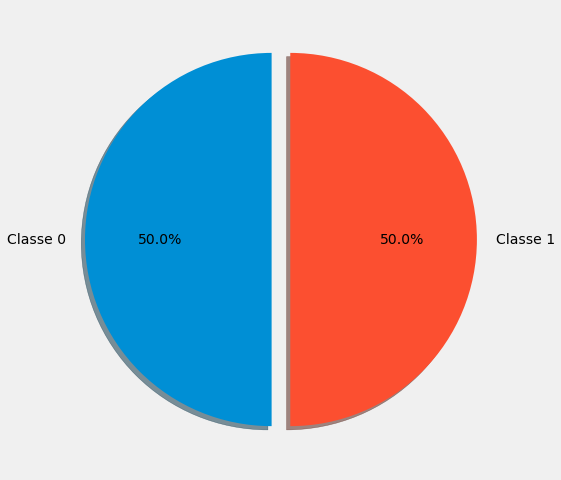

In [62]:
target_count = y_smt.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

plt.figure(figsize=(8,8))

plt.pie(target_count, explode=[0, 0.1], labels=["Classe 0", "Classe 1"], autopct='%1.1f%%',
        shadow=True, startangle=90)

## Analyse de la baseline avec les données réequilibrées


In [63]:
print (X_smt.shape)
print (X_test.shape)

print (y_smt.shape)
print (y_test.shape)

if (X_smt.shape[1] != X_test.shape[1]):
    # Alignement
    # Align the dataframes
    X_smt, X_test = X_smt.align(X_test, join = 'inner', axis = 1)

    # Print out the new shapes
    print('Training data shape: ', X_smt.shape)
    print('Testing data shape:  ', X_test.shape)

(49650, 239)
(61503, 239)
(49650,)
(61503,)


In [64]:
# On crée le dataframe de résultats
df_results_base = pd.DataFrame(y_test.values, columns=["y_true"], index=y_test.index)

# On lance les prédictions
log_reg_pred = log_reg(X_smt, y_smt, y_test, X_test)

# On enregistre les résultats
df_results_base = save_results(df_results_base, log_reg_pred, "y_pred_lr", y_test)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base["y_pred_lr_bin"] = transform_treshold(df_results_base["y_pred_lr"], 0.5)

display(df_results_base.head())
print(df_results_base.shape)

Accuracy: 61.24%


y_true  y_pred_lr  y_pred_lr_bin
42962        1   0.521760              1
227307       0   0.437671              0
290035       0   0.446603              0
239833       0   0.553600              1
76427        0   0.531317              1

(61503, 3)


In [65]:
# On crée le dataframe de résultats
df_results_base_poly = pd.DataFrame(y_test_poly.values, columns=["y_true"], index=y_test_poly.index)

# On lance les prédictions
log_reg_pred = log_reg(X_smt_poly, y_smt_poly, y_test_poly, X_test_poly)

# On enregistre les résultats
df_results_base_poly = save_results(df_results_base_poly, log_reg_pred, "y_pred_lr_poly", y_test_poly)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_poly["y_pred_lr_poly_bin"] = transform_treshold(df_results_base_poly["y_pred_lr_poly"], 0.5)

display(df_results_base_poly.head())
print(df_results_base_poly.shape)

Accuracy: 64.67%


y_true  y_pred_lr_poly  y_pred_lr_poly_bin
42962        1        0.591027                   1
227307       0        0.342749                   0
290035       0        0.498782                   0
239833       0        0.527568                   1
76427        0        0.599995                   1

(61503, 3)


In [66]:
# On crée le dataframe de résultats
df_results_base_domain = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

# On lance les prédictions
log_reg_pred = log_reg(X_smt_domain, y_smt_domain, y_test_domain, X_test_domain)

# On enregistre les résultats
df_results_base_domain = save_results(df_results_base_domain, log_reg_pred, "y_pred_lr_domain", y_test_domain)

# On "binarise" les probabilités avec un treshold parametré à 0.5
# Par exemple, pour un treshold de 0.5, si la probabilité en est inférieure la valeur sera de 0. Sinon elle sera de 1.
# Et on concatène les données à notre tableau de résultats
df_results_base_domain["y_pred_lr_domain_bin"] = transform_treshold(df_results_base_domain["y_pred_lr_domain"], 0.5)

display(df_results_base_domain.head())
print(df_results_base_domain.shape)

Accuracy: 61.30%


y_true  y_pred_lr_domain  y_pred_lr_domain_bin
42962        1          0.520171                     1
227307       0          0.440494                     0
290035       0          0.449340                     0
239833       0          0.556116                     1
76427        0          0.529789                     1

(61503, 3)


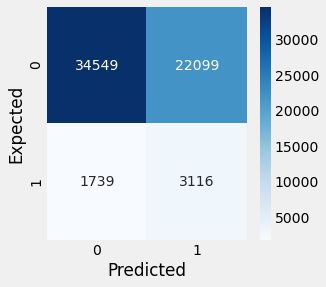

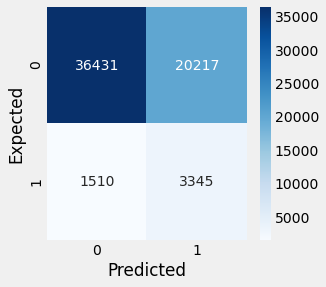

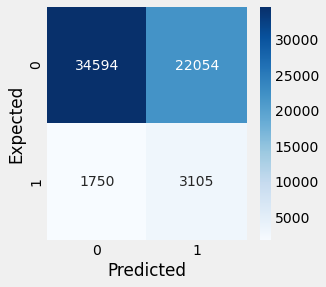

In [67]:
aff_confusion_matrix(df_results_base["y_true"], df_results_base["y_pred_lr_bin"])

aff_confusion_matrix(df_results_base_poly["y_true"], df_results_base_poly["y_pred_lr_poly_bin"])

aff_confusion_matrix(df_results_base_domain["y_true"], df_results_base_domain["y_pred_lr_domain_bin"])

In [68]:
df_metrics_base = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["sans_feat_eng", "poly_feat", "domain_feat"])

df_metrics_base["Accuracy"][0] = round(accuracy_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Precision"][0] = round(precision_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["Recall"][0] = round(recall_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)
df_metrics_base["F1_score"][0] = round(f1_score(df_results_base["y_true"], df_results_base.iloc[:, 2]), 2)

df_metrics_base["Accuracy"][1] = round(accuracy_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["Precision"][1] = round(precision_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["Recall"][1] = round(recall_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)
df_metrics_base["F1_score"][1] = round(f1_score(df_results_base_poly["y_true"], df_results_base_poly.iloc[:, 2]), 2)

df_metrics_base["Accuracy"][2] = round(accuracy_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Precision"][2] = round(precision_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["Recall"][2] = round(recall_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)
df_metrics_base["F1_score"][2] = round(f1_score(df_results_base_domain["y_true"], df_results_base_domain.iloc[:, 2]), 2)

df_metrics_base

Accuracy Precision Recall F1_score
sans_feat_eng     0.61      0.12   0.64     0.21
poly_feat         0.65      0.14   0.69     0.24
domain_feat       0.61      0.12   0.64     0.21

Les résultats semblent favorable au poly_feat, mais je vais quand même continuer avec le domain_feat, même si une approche combinée mériterait qu'on s'y intéresse.

# Optimisation du modèle

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import pickle

dataframe de résultats

In [70]:
df_results = pd.DataFrame(y_test_domain.values, columns=["y_true"], index=y_test_domain.index)

## Régression logistique

In [71]:
%%time

# Make the model with the specified regularization parameter
clf_lr = LogisticRegression(C=10)

# Train on the training data
clf_lr.fit(X_smt_domain, y_smt_domain)

# Make predictions
# Make sure to select the second column only
lr_pred_smoted = clf_lr.predict_proba(X_test_domain)[:, 1]

# Submission dataframe
df_results["y_pred_lr_smoted"] = lr_pred_smoted

df_results.head()

Wall time: 2.98 s


y_true  y_pred_lr_smoted
42962        1          0.782274
227307       0          0.263224
290035       0          0.468948
239833       0          0.371471
76427        0          0.803407

In [72]:
# saving the model
with open("model_clf_lr.bin", 'wb') as f_out:
    pickle.dump(clf_lr, f_out)
    f_out.close()

treshold sur 0.5.

In [73]:
df_results["y_pred_lr_smoted_bin"] = transform_treshold(df_results["y_pred_lr_smoted"], 0.5)

df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin
42962        1          0.782274                     1
227307       0          0.263224                     0
290035       0          0.468948                     0
239833       0          0.371471                     0
76427        0          0.803407                     1

## Random Forest

In [74]:
%%time

# Make the model with the specified regularization parameter
clf_rf = RandomForestClassifier(n_estimators=1000,
                                max_depth=10
                               )

# Train on the training data
clf_rf.fit(X_smt_domain, y_smt_domain)

# Make predictions
# Make sure to select the second column only
rf_pred_smoted = clf_rf.predict_proba(X_test_domain)[:, 1]

# Submission dataframe
df_results["y_pred_rf_smoted"] = rf_pred_smoted

df_results.head()

Wall time: 2min 1s


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted
42962        1          0.782274                     1          0.652328
227307       0          0.263224                     0          0.262173
290035       0          0.468948                     0          0.438346
239833       0          0.371471                     0          0.420611
76427        0          0.803407                     1          0.607185

In [75]:
# saving the model
with open("model_clf_rf.bin", 'wb') as f_out:
    pickle.dump(clf_rf, f_out)
    f_out.close()

In [76]:
df_results["y_pred_rf_smoted_bin"] = transform_treshold(df_results["y_pred_rf_smoted"], 0.5)

df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
42962        1          0.782274                     1          0.652328   
227307       0          0.263224                     0          0.262173   
290035       0          0.468948                     0          0.438346   
239833       0          0.371471                     0          0.420611   
76427        0          0.803407                     1          0.607185   

        y_pred_rf_smoted_bin  
42962                      1  
227307                     0  
290035                     0  
239833                     0  
76427                      1

## XGBoost

In [77]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            random_state=0)

clf_xgb.fit(X_smt_domain, y_smt_domain)

# Make predictions
# Make sure to select the second column only
xgb_pred_smoted = clf_xgb.predict_proba(X_test_domain)[:, 1]

# Submission dataframe
df_results["y_pred_xgb_smoted"] = xgb_pred_smoted
    
df_results.head()


[19:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
42962        1          0.782274                     1          0.652328   
227307       0          0.263224                     0          0.262173   
290035       0          0.468948                     0          0.438346   
239833       0          0.371471                     0          0.420611   
76427        0          0.803407                     1          0.607185   

        y_pred_rf_smoted_bin  y_pred_xgb_smoted  
42962                      1           0.887653  
227307                     0           0.295808  
290035                     0           0.484900  
239833                     0           0.344677  
76427                      1           0.800250

In [78]:
X_test_domain.shape

(61503, 243)

In [79]:
# saving the model
with open("model_clf_xgb.bin", 'wb') as f_out:
    pickle.dump(clf_xgb, f_out)
    f_out.close()

In [80]:
df_results["y_pred_xgb_smoted_bin"] = transform_treshold(df_results["y_pred_xgb_smoted"], 0.5)

df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
42962        1          0.782274                     1          0.652328   
227307       0          0.263224                     0          0.262173   
290035       0          0.468948                     0          0.438346   
239833       0          0.371471                     0          0.420611   
76427        0          0.803407                     1          0.607185   

        y_pred_rf_smoted_bin  y_pred_xgb_smoted  y_pred_xgb_smoted_bin  
42962                      1           0.887653                      1  
227307                     0           0.295808                      0  
290035                     0           0.484900                      0  
239833                     0           0.344677                      0  
76427                      1           0.800250                      1

## Gradient Boosting Classifier

In [81]:
%%time

# Create the model
clf_lgb = lgb.LGBMClassifier(n_estimators=10000,
                             objective='binary',
                             class_weight='balanced',
                             learning_rate=0.05,
                             reg_alpha=0.1,
                             reg_lambda=0.1,
                             subsample=0.8,
                             n_jobs=-1,
                             random_state=0
                            )

# Train on the training data
clf_lgb.fit(X_smt_domain, y_smt_domain)

# Make predictions
# Make sure to select the second column only
lgb_pred_smoted = clf_lgb.predict_proba(X_test_domain)[:, 1]

# Submission dataframe
df_results["y_pred_lgb_smoted"] = lgb_pred_smoted
    
df_results.head()

Wall time: 1min 54s


y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
42962        1          0.782274                     1          0.652328   
227307       0          0.263224                     0          0.262173   
290035       0          0.468948                     0          0.438346   
239833       0          0.371471                     0          0.420611   
76427        0          0.803407                     1          0.607185   

        y_pred_rf_smoted_bin  y_pred_xgb_smoted  y_pred_xgb_smoted_bin  \
42962                      1           0.887653                      1   
227307                     0           0.295808                      0   
290035                     0           0.484900                      0   
239833                     0           0.344677                      0   
76427                      1           0.800250                      1   

        y_pred_lgb_smoted  
42962            0.982923  
227307           0.048318  
290035           0.257146  
239833           0.331861  
76427            0.991979

In [82]:
# saving the model
with open("model_clf_lgb.bin", 'wb') as f_out:
    pickle.dump(clf_lgb, f_out)
    f_out.close()

In [83]:
df_results["y_pred_lgb_smoted_bin"] = transform_treshold(df_results["y_pred_lgb_smoted"], 0.5)

df_results.head()

y_true  y_pred_lr_smoted  y_pred_lr_smoted_bin  y_pred_rf_smoted  \
42962        1          0.782274                     1          0.652328   
227307       0          0.263224                     0          0.262173   
290035       0          0.468948                     0          0.438346   
239833       0          0.371471                     0          0.420611   
76427        0          0.803407                     1          0.607185   

        y_pred_rf_smoted_bin  y_pred_xgb_smoted  y_pred_xgb_smoted_bin  \
42962                      1           0.887653                      1   
227307                     0           0.295808                      0   
290035                     0           0.484900                      0   
239833                     0           0.344677                      0   
76427                      1           0.800250                      1   

        y_pred_lgb_smoted  y_pred_lgb_smoted_bin  
42962            0.982923                      1  
227307           0.048318                      0  
290035           0.257146                      0  
239833           0.331861                      0  
76427            0.991979                      1

## Analyse des résultats

### Matrice de confusion


Matrice confusion régression logistique


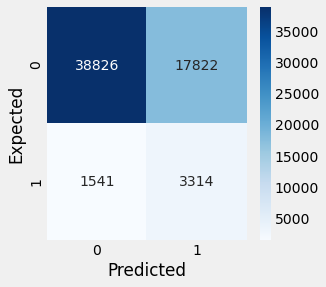

Matrice confusion random forest


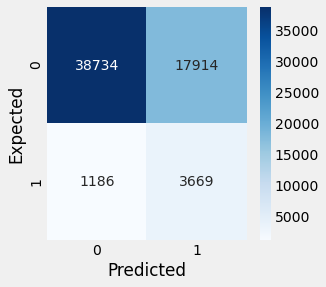

Matrice confusion LGBMClassifier


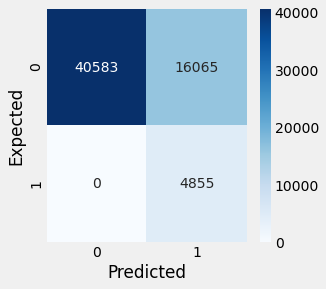

Matrice confusion XGBoost


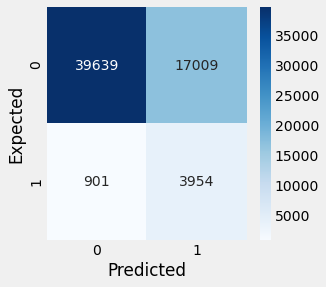

In [84]:
print("Matrice confusion régression logistique")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_lr_smoted_bin"])

print("Matrice confusion random forest")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_rf_smoted_bin"])

print("Matrice confusion LGBMClassifier")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_lgb_smoted_bin"])

print("Matrice confusion XGBoost")
aff_confusion_matrix(df_results["y_true"], df_results["y_pred_xgb_smoted_bin"])

## Accuracy, Precision, Recall, F1 score


In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

nb_models = 4

df_metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_score"], index=["Logistic regression", "Random Forest", "XGBoost", "Gradient Boosting Classifier"])

# j=3 représente la 3eme colonne du dataframe df_results
# on cible les colonnes de valeurs prédites avec cette variable
j = 2

for i in np.arange(0, nb_models):
    
    df_metrics["Accuracy"][i] = round(accuracy_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Precision"][i] = round(precision_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["Recall"][i] = round(recall_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    df_metrics["F1_score"][i] = round(f1_score(df_results["y_true"], df_results.iloc[:, j]), 2)
    
    j += 2

nom_fic = 'df_metrics_'+mode_sampling+'.csv'
df_metrics.to_csv(nom_fic)
#df_metrics.to_csv('df_metrics_over_sampling.csv')
#df_metrics.to_csv('df_metrics_smoteen.csv')
#df_metrics.to_csv('df_metrics_SMOTETomek.csv')

df_metrics

Accuracy Precision Recall F1_score
Logistic regression              0.69      0.16   0.68     0.26
Random Forest                    0.69      0.17   0.76     0.28
XGBoost                          0.71      0.19   0.81     0.31
Gradient Boosting Classifier     0.74      0.23      1     0.38

### Résultats
#### Under_sampling
Il y a un soucis avec le LGBM, faudrait approfondir. Le résultat est trop parfait.
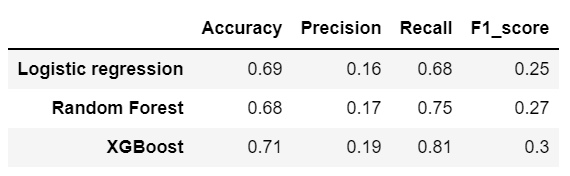

#### Over_sampling
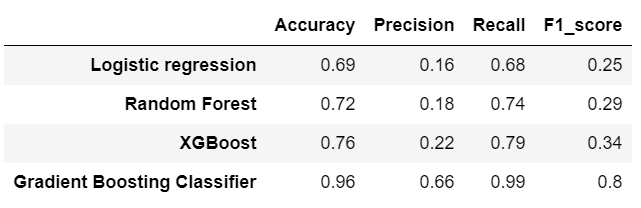

#### SMOTEENN
Trop long

#### SMOTETomek
Trop long


## Receiver Operating Characteristic (ROC)

In [86]:
from sklearn.metrics import roc_curve

fp_lr, tp_lr, treshold_lr = roc_curve(y_test_domain, lr_pred_smoted)
fp_rf, tp_rf, treshold_rf = roc_curve(y_test_domain, rf_pred_smoted)
fp_lgb, tp_lgb, treshold_lgb = roc_curve(y_test_poly, lgb_pred_smoted)
fp_xgb, tp_xgb, treshold_xgb = roc_curve(y_test_domain, xgb_pred_smoted)

In [87]:
from sklearn.metrics import roc_auc_score

auc_score_lr = roc_auc_score(y_test_domain, lr_pred_smoted)
auc_score_rf = roc_auc_score(y_test_domain, rf_pred_smoted)
auc_score_lgb = roc_auc_score(y_test_poly, lgb_pred_smoted)
auc_score_xgb = roc_auc_score(y_test_domain, xgb_pred_smoted)

lst_auc_score = [("Logistic Regression", auc_score_lr),
                ("Random Forest", auc_score_rf),
                #("LGBMClassifier", auc_score_lgb),
                ("XGBoost", auc_score_xgb)]

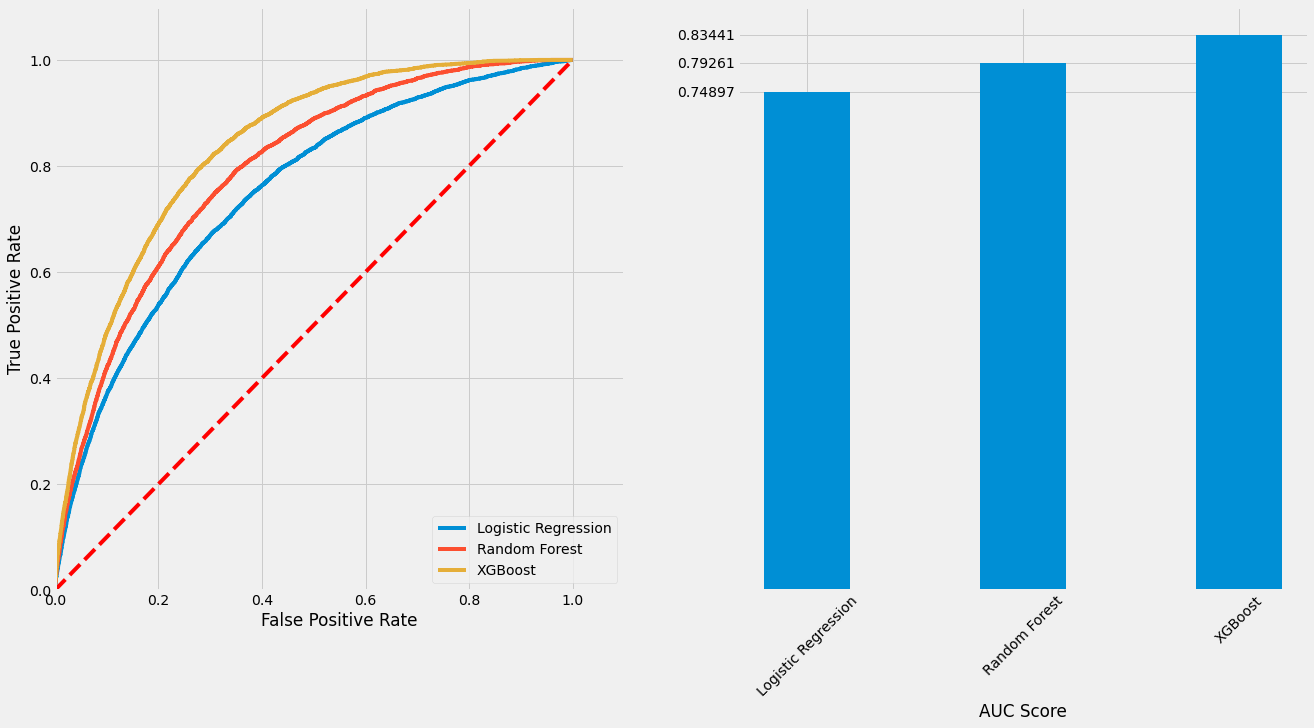

In [88]:
plt.figure(figsize=(20,10))


plt.subplot(1, 2, 1)

plt.plot(fp_lr, tp_lr, label="Logistic Regression")
plt.plot(fp_rf, tp_rf, label="Random Forest")
#plt.plot(fp_lgb, tp_lgb, label="LGBMClassifier")
plt.plot(fp_xgb, tp_xgb, label="XGBoost")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.subplot(1, 2, 2)

plt.style.use('fivethirtyeight')

labels, ys = zip(*lst_auc_score)

xs = np.arange(len(labels)) 

width = 0.4

plt.bar(xs, ys, width, align='center')

plt.xlabel("AUC Score")
plt.xticks(xs, labels, rotation=45) 
plt.yticks(ys)
plt.show()


In [89]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

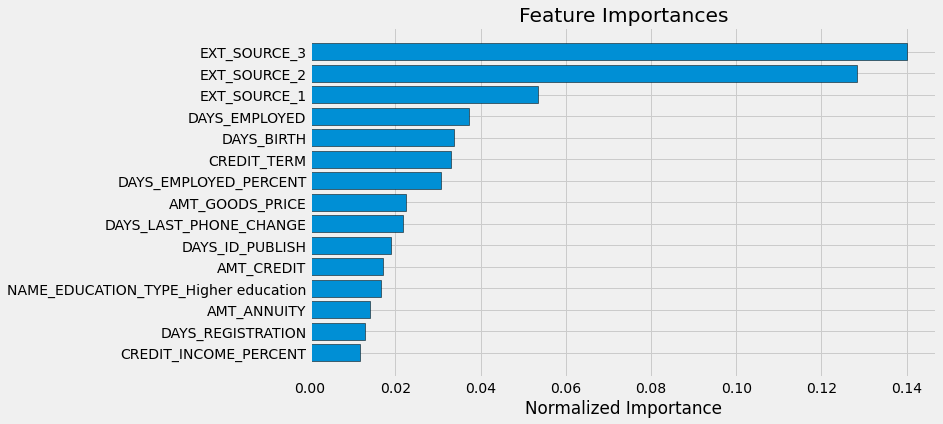

In [90]:
# Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': app_test_domain.columns, 'importance': clf_rf.feature_importances_})

fi_sorted = plot_feature_importances(feature_importances)

## Conclusion sur modeling

Le XGBoost est pas mal le LGB semble trop parfait, il y a un bug. Faudrait refaire le test avec Pycaret


### Réduction de dimension PCA - TSNE
Pour voir si on peut distinguer les deux classes sur une des projections. Simple curiosité.
Si on pouvait voir deux zones, ce serait fantastique !!

In [91]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score


In [92]:
# Affichage d'une liste de Box Plot
# ---------------------------------
def affiche_liste_boxplot (data, liste):
    modalites = liste   
    
    groupes = []
    for m in modalites:
        groupes.append(data[m])

    # Propriétés graphiques (pas très importantes)    
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}
    plt.figure(figsize=(12,2*len(liste)))
    #plt.title('Box plot pour visualiser les outliers', size=15)
    plt.grid()
    plt.boxplot(groupes, labels=modalites, showfliers=True, medianprops=medianprops, 
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()
    
# Affichage d'une liste de distribution
# -------------------------------------
def affiche_distrib(data, liste):
    for column in liste:
        plt.figure(figsize = (10,2))
        sns.set(font_scale=1)
        #sns.distplot(data[column], bins=50)
        #sns.displot(data[column], bins=50)
        sns.histplot(data[column], bins=250, kde=True)
        chaine = 'Distribution de : ' + column
        plt.title(chaine)
        plt.xlabel(column)
        #plt.savefig(chaine)
        plt.show()

# Drop sécurisé d'une liste de colonnes
# -------------------------------------
def drop_columns(columns_to_drop, dataset):
    for column in columns_to_drop:
        try:
            dataset.drop(column, axis=1, inplace=True)
        except:
            print('colonne {} absente du jeu de donnée'.format(column))
        
    return (dataset)

# Affichage de la variance expliquée d'une PCA
# --------------------------------------------
def view_explained_variance (pca, nb_lambda, dataset):
    plt.figure(figsize=(12,5))
    plt.title("Somme cumulée de variance des composantes de l'ACP sur {}".format(dataset))
    plt.xlabel("Nombre de composantes de l'ACP")
    plt.ylabel("Variance cumulée")
    plt.plot(list(range(nb_lambda)), np.cumsum(pca.explained_variance_ratio_))

# Affichage des cercles d'une PCA
# --------------------------------------------
def view_circle_pca(pca, colonnes_pca, cmp1=0, cmp2=1):
    from matplotlib.patches import Circle
    plt.figure(figsize=(10,10)) ## test

    sns.set_context("paper", font_scale=1.5) 
    plt.figure(figsize=(15,15))
    chaine = "Plan factoriel sur {}-{} de l'ACP".format(cmp1,cmp2)
    plt.title(chaine)
    plt.xlabel('Composante {}'.format(cmp1))
    plt.ylabel('Composante {}'.format(cmp2))
    ax = plt.gca()
    ax.add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', 
                    clip_on=False))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    x_pca = pca.components_[cmp1,:]
    y_pca = pca.components_[cmp2,:]

    sns.scatterplot(x = x_pca,
                    y = y_pca,
                    alpha = 0.7)
    plt.plot([-1,1],[0,0], color='grey', alpha=0.8)
    plt.plot([0,0],[-1,1], color='grey', alpha=0.8)

    i = 0
    for x,y,colonne in zip(x_pca,y_pca, colonnes_pca):

        plt.annotate(colonne, 
                     (x,y), 
                     textcoords="offset points", 
                     xytext=(0,5+np.random.randint(-10,10)),
                     ha='center') 
        ax.arrow(0, 0, x, y, head_width=0, head_length=0, fc='grey', ec='grey',
                 alpha=0.2)

    sns.set_context("paper", font_scale=1)


def view_project_pca(title, xlabel, ylabel, x_data, y_data):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    ax = plt.gca()

    sns.scatterplot(x = x_data,
                y = y_data,
                #hue = hue_show,
                alpha=0.8, s=10)

    sns.set_context("paper", font_scale=1) 

def view_2D (x, y, hue, title):
    plt.figure(figsize=(12,12))
    plt.title(title)
    #print (len(np.unique(hue)))
    sns.scatterplot(x=x, y=y, hue=hue, legend='full',
               palette=sns.color_palette("hls", len(np.unique(hue))))
    #sns.scatterplot(x=x, y=y, hue=hue, legend='full')    


# fonction qui trace le graphique des eboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    #plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='.')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


In [93]:
n_comp=0.95
Dataset = 'X_smt_domain'

pca = PCA (random_state=1, n_components=n_comp)
pca.fit(X_smt_domain)
print (X_smt_domain.shape)
print (pca.components_.shape)

(49650, 243)
(78, 243)


In [94]:
X_pca = pca.transform(X_smt_domain)[:,:78]
print (X_pca.shape)


(49650, 78)


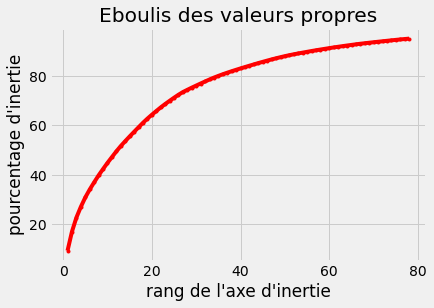

<Figure size 432x288 with 0 Axes>

In [95]:
# graphique eboulis des valeurs propres
display_scree_plot(pca)
file =  'PCA_eig_sur_{}.png'.format(Dataset)
plt.savefig(file)

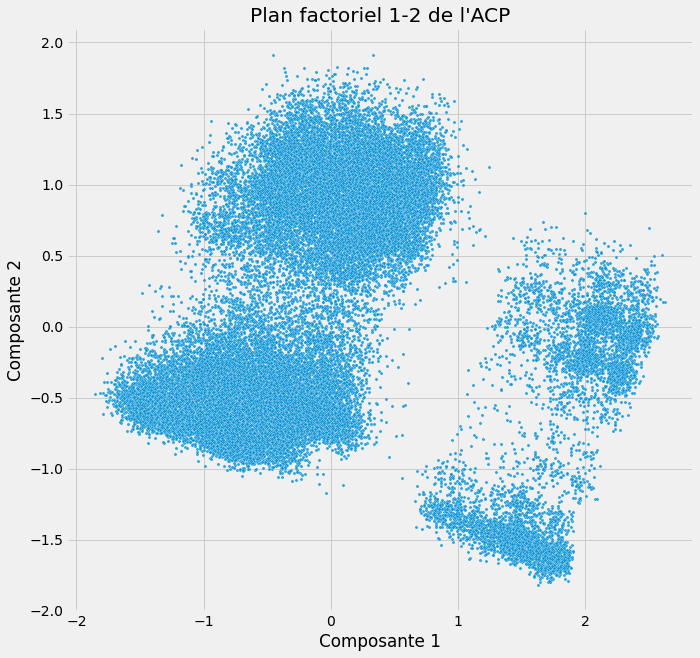

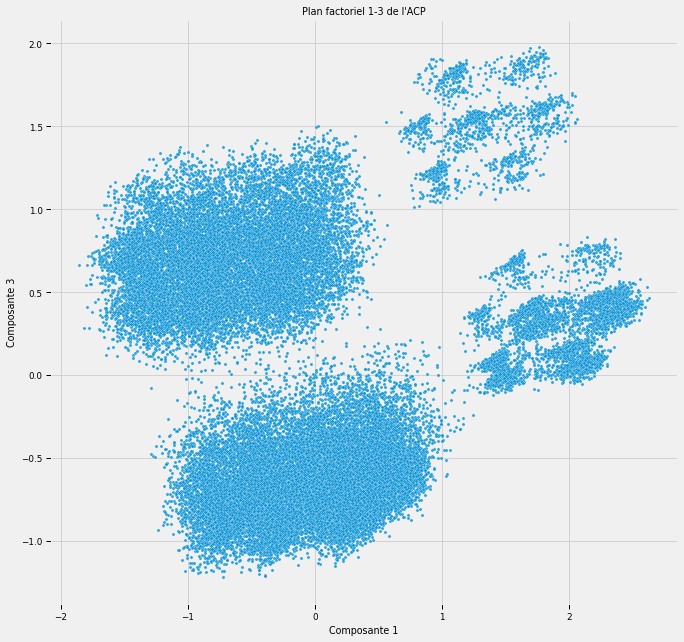

In [96]:
view_project_pca("Plan factoriel 1-2 de l'ACP",'Composante 1', 'Composante 2', X_pca[:,0], X_pca[:,1])
file =  'plots/PCA_plan_factoriel_0_1_sur_{}.png'.format(Dataset)
plt.savefig(file)

view_project_pca("Plan factoriel 1-3 de l'ACP",'Composante 1', 'Composante 3', X_pca[:,0], X_pca[:,2])
file =  'plots/PCA_plan_factoriel_0_2_sur_{}.png'.format(Dataset)
plt.savefig(file)

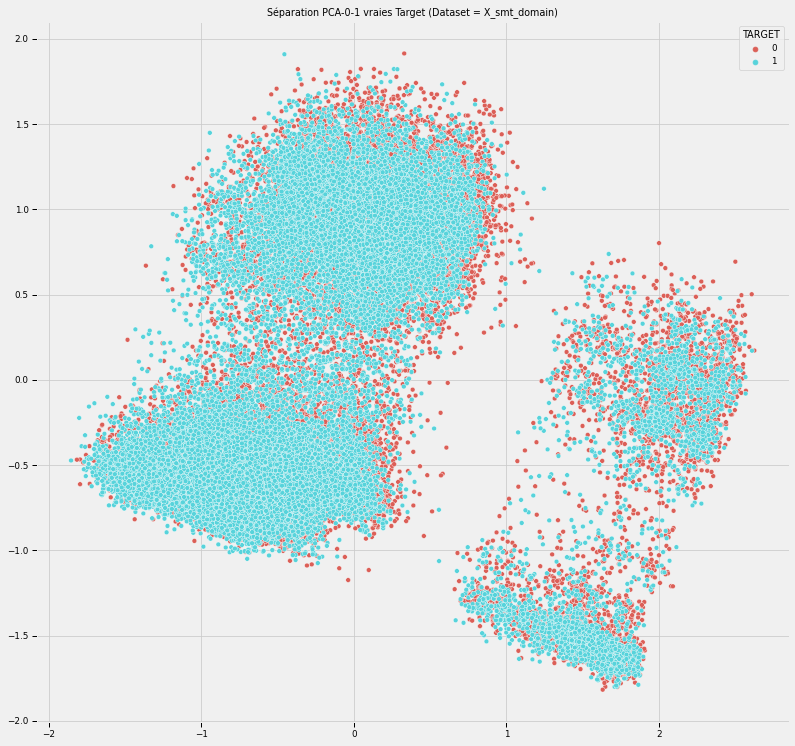

In [97]:
titre = 'Séparation PCA-0-1 vraies Target (Dataset = {})'.format(Dataset)
file =  'plots/Pca_0-1_vraies_target_{}.png'.format(Dataset)
view_2D (X_pca[:,0], X_pca[:,1], y_smt_domain , titre)
plt.savefig(file)

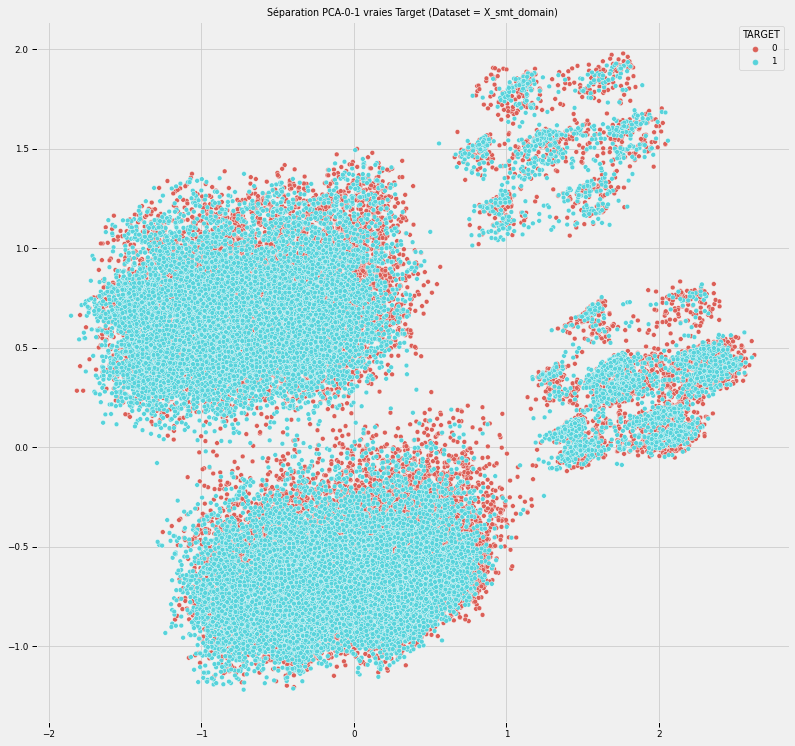

In [98]:
titre = 'Séparation PCA-0-1 vraies Target (Dataset = {})'.format(Dataset)
file =  'plots/Pca_1-3_vraies_target_{}.png'.format(Dataset)
view_2D (X_pca[:,0], X_pca[:,2], y_smt_domain , titre)
plt.savefig(file)

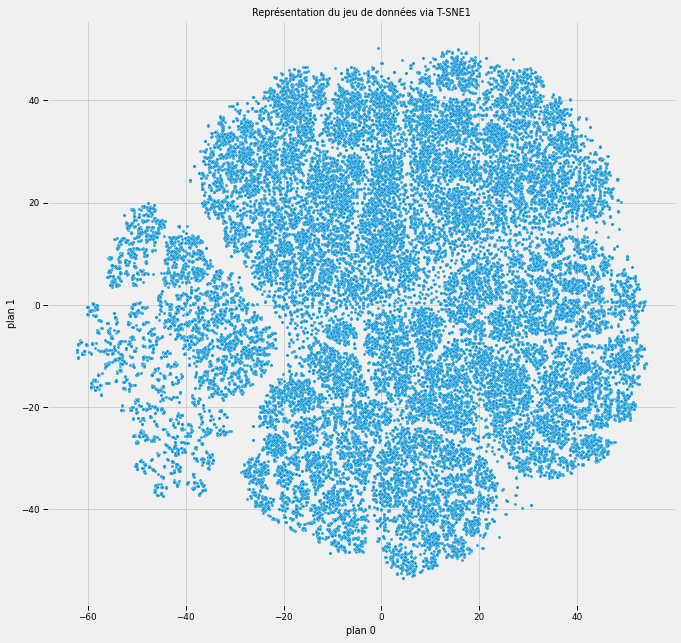

In [99]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
T1 = tsne.fit_transform(X_pca.copy())  # X_pca ou X
view_project_pca('Représentation du jeu de données via T-SNE1', 'plan 0', 'plan 1', T1[:,0], T1[:,1])


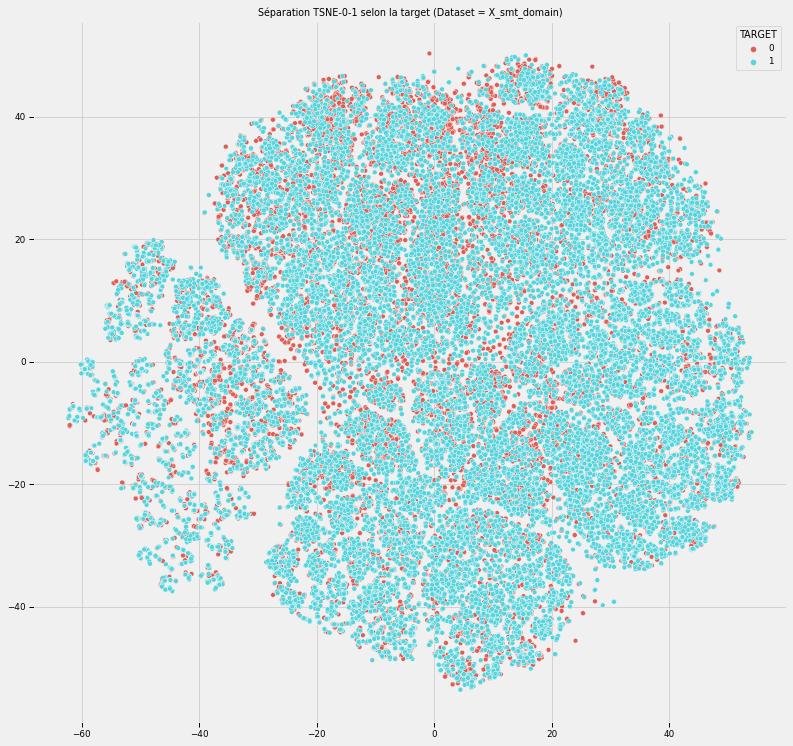

In [100]:
titre = 'Séparation TSNE-0-1 selon la target (Dataset = {})'.format(Dataset)
file =  'plots/Tsne_0-1_selon_target_sur_{}.png'.format(Dataset)
view_2D (T1[:,0], T1[:,1], y_smt_domain , titre)
plt.savefig(file)


### PCA - TSNE Sur les données avant reampling

In [101]:
# train, app_train["TARGET"]

In [102]:
n_comp=0.95
Dataset = 'train'

pca = PCA (random_state=1, n_components=n_comp)
pca.fit(train)
print (train.shape)
print (pca.components_.shape)

(307511, 239)
(78, 239)


In [103]:
X_pca = pca.transform(train)[:,:78]
print (X_pca.shape)


(307511, 78)


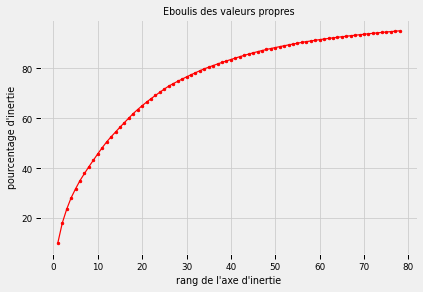

<Figure size 432x288 with 0 Axes>

In [104]:
# graphique eboulis des valeurs propres
display_scree_plot(pca)
file =  'PCA_eig_sur_{}.png'.format(Dataset)
plt.savefig(file)

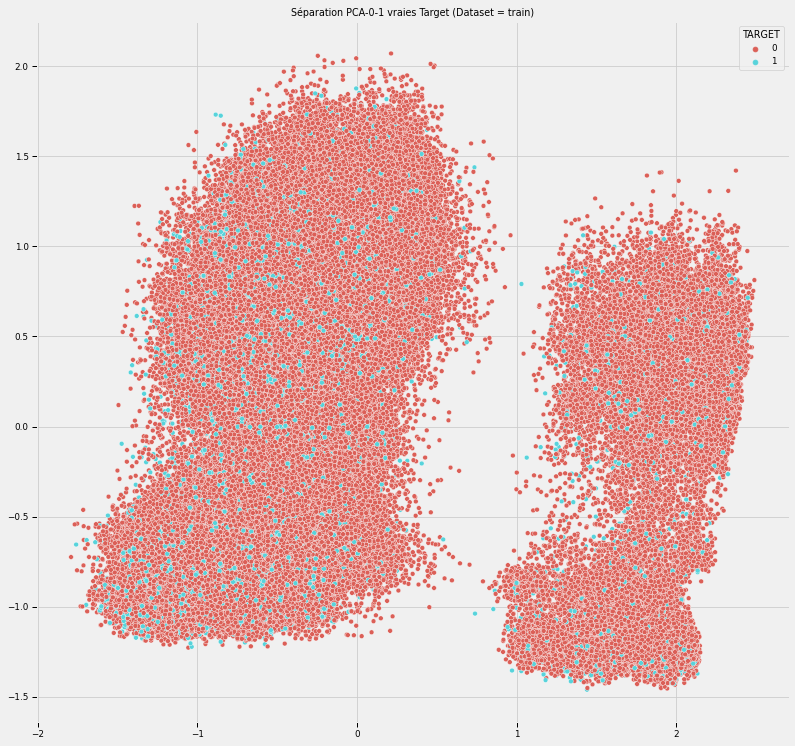

In [105]:
titre = 'Séparation PCA-0-1 vraies Target (Dataset = {})'.format(Dataset)
file =  'plots/Pca_0-1_vraies_target_{}.png'.format(Dataset)
view_2D (X_pca[:,0], X_pca[:,1], app_train["TARGET"] , titre)
plt.savefig(file)